# User Engagement Analysis

## 1. Introduction

This notebook analyzes user engagement behavior to understand patterns of retention and usage, and to identify factors associated with higher long-term engagement.

The goals of this analysis are to:
- Explore and validate the structure and quality of the dataset
- Define a clear engagement or retention outcome
- Identify key behavioral and user attributes correlated with engagement
- Build an interpretable baseline model (if applicable)
- Summarize findings and actionable recommendations

This notebook is structured as a reproducible, step-by-step analysis suitable for stakeholder review and technical evaluation.

---

## 2. Analysis Index

1. **Data Loading & Initial Inspection**
   - Dataset shape, columns, and data types
   - Missing value analysis
   - Initial sanity checks

2. **Problem Definition & Success Metrics**
   - Definition of engagement / retention
   - Business framing and evaluation metrics

3. **Exploratory Data Analysis (EDA)**
   - User activity distributions
   - Time-based engagement patterns
   - Cohort or segmentation analysis (if applicable)

4. **Feature Engineering**
   - Behavioral aggregations
   - Time-window features
   - Categorical encoding

5. **Modeling (Baseline & Advanced)**
   - Baseline heuristic or rule-based benchmark
   - Interpretable model (e.g., Logistic Regression)
   - Optional advanced model (e.g., Random Forest)

6. **Model Evaluation**
   - Performance metrics
   - Feature importance / coefficients
   - Error analysis

7. **Key Findings & Insights**
   - What drives engagement?
   - High-risk vs high-value user behaviors

8. **Recommendations & Next Steps**
   - Product or business recommendations
   - Ideas for further analysis or data collection


## Step 1 — Load the data + quick inspection

Goal:
- Load the CSV
- Validate row/column counts
- Preview columns + data types
- Check missing values
- Get quick summary stats (numeric + categorical)

Dataset:
- `takehome_user_engagement.csv`


In [5]:
import pandas as pd
import numpy as np

DATA_PATH = "takehome_user_engagement.csv"

df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())

display(df.head(10))

print("\nDtypes:\n")
print(df.dtypes)

# Missing values
missing = (
    df.isna()
      .sum()
      .sort_values(ascending=False)
      .to_frame("missing_count")
)
missing["missing_pct"] = (missing["missing_count"] / len(df) * 100).round(2)
display(missing[missing["missing_count"] > 0])

# Basic summary
print("\nNumeric summary:")
display(df.describe(include=[np.number]).T)

print("\nCategorical summary (top counts):")
cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
for c in cat_cols[:15]:  # limit to avoid huge output if many columns
    print(f"\n--- {c} ---")
    display(df[c].value_counts(dropna=False).head(10))


Shape: (207917, 3)

Columns:
 ['time_stamp', 'user_id', 'visited']


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1
6,2014-01-08 03:45:04,2,1
7,2014-02-03 03:45:04,2,1
8,2014-02-08 03:45:04,2,1
9,2014-02-09 03:45:04,2,1



Dtypes:

time_stamp    object
user_id        int64
visited        int64
dtype: object


,missing_count,missing_pct



Numeric summary:


,count,mean,std,min,25%,50%,75%,max
user_id,207917.0,5913.314197,3394.941674,1.0,3087.0,5682.0,8944.0,12000.0
visited,207917.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0



Categorical summary (top counts):

--- time_stamp ---


time_stamp
2013-04-06 21:21:37    2
2013-10-04 21:21:37    2
2014-01-20 07:46:58    2
2013-10-07 21:21:37    2
2014-01-29 01:13:02    2
2013-08-18 17:13:38    2
2013-08-20 17:13:38    2
2014-04-02 13:40:27    2
2014-04-03 13:40:27    2
2014-04-04 13:40:27    2
Name: count, dtype: int64

## Step 2 — Problem Definition & Success Metric

### Problem Statement

We are given raw user activity logs consisting of timestamps of user visits.
There is no explicit label indicating whether a user is "engaged" or "retained".

Our task is to:
- Define a meaningful engagement metric
- Label users based on that definition
- Use this label for downstream analysis and modeling

### Engagement Definition (Adopted User)

We define an **engaged (adopted) user** as:

> A user who has visited the product on **at least 3 distinct days within any 7-day window**

Rationale:
- Filters out one-time or accidental users
- Captures sustained short-term engagement
- Common industry heuristic for activation/retention analysis
- Balances strictness and interpretability

### Success Metric

Primary target variable:
- `adopted_user` ∈ {0, 1}

This binary label will be used for:
- Exploratory analysis
- Feature engineering
- Predictive modeling (optional)


In [8]:
# Step 2 — Define adopted (engaged) users

df_step2 = df.copy()

# Convert timestamp to datetime
df_step2["time_stamp"] = pd.to_datetime(df_step2["time_stamp"])

# Extract date only (day-level granularity)
df_step2["date"] = df_step2["time_stamp"].dt.date

# Sort for rolling window logic
df_step2 = df_step2.sort_values(["user_id", "date"])

# Deduplicate same-day visits
daily_visits = (
    df_step2
    .drop_duplicates(subset=["user_id", "date"])
    .reset_index(drop=True)
)

def is_adopted(user_dates):
    """
    Returns True if user has >= 3 visits within any 7-day window
    """
    dates = pd.Series(user_dates).sort_values()
    for i in range(len(dates)):
        if i + 2 < len(dates):
            if (dates.iloc[i + 2] - dates.iloc[i]).days <= 6:
                return True
    return False

# Apply per user
adopted_flag = (
    daily_visits
    .groupby("user_id")["date"]
    .apply(is_adopted)
    .reset_index(name="adopted_user")
)

# Merge back to user-level table
display(adopted_flag["adopted_user"].value_counts())
display(adopted_flag.head())


adopted_user
False    7221
True     1602
Name: count, dtype: int64

,user_id,adopted_user
0,1,False
1,2,True
2,3,False
3,4,False
4,5,False


## Step 3 — Engagement Label Validation & User-Level EDA

### Objectives
- Validate that the adopted_user label behaves as expected
- Compare engagement patterns between adopted and non-adopted users
- Identify early signals that differentiate engaged users

### Key Questions
- How many days do users typically visit?
- Do adopted users visit more frequently?
- Are adoption patterns visible early in the user lifecycle?


In [13]:
# Build user-level metrics (FIXED)

user_metrics = (
    daily_visits
    .groupby("user_id")
    .agg(
        total_active_days=("date", "nunique"),
        first_visit=("date", "min"),
        last_visit=("date", "max")
    )
    .reset_index()
)

# Convert to datetime before subtraction
user_metrics["first_visit"] = pd.to_datetime(user_metrics["first_visit"])
user_metrics["last_visit"] = pd.to_datetime(user_metrics["last_visit"])

user_metrics["active_span_days"] = (
    user_metrics["last_visit"] - user_metrics["first_visit"]
).dt.days

# Merge adopted label
user_metrics = user_metrics.merge(adopted_flag, on="user_id", how="left")

display(user_metrics.head())


,user_id,total_active_days,first_visit,last_visit,active_span_days,adopted_user
0,1,1,2014-04-22,2014-04-22,0,False
1,2,14,2013-11-15,2014-03-31,136,True
2,3,1,2013-03-19,2013-03-19,0,False
3,4,1,2013-05-22,2013-05-22,0,False
4,5,1,2013-01-22,2013-01-22,0,False


In [15]:
# Summary statistics by adoption status
summary = (
    user_metrics
    .groupby("adopted_user")
    .agg(
        users=("user_id", "count"),
        avg_active_days=("total_active_days", "mean"),
        median_active_days=("total_active_days", "median"),
        avg_active_span=("active_span_days", "mean")
    )
    .round(2)
)

display(summary)


,users,avg_active_days,median_active_days,avg_active_span
adopted_user,,,,
False,7221,1.38,1.0,4.75
True,1602,123.54,68.0,299.26


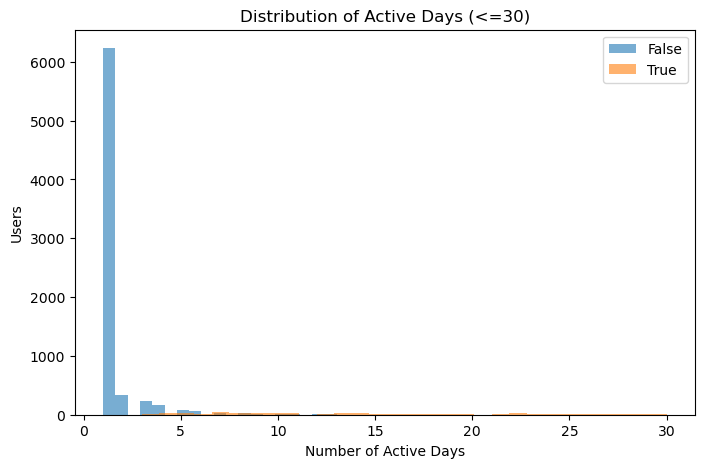

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
user_metrics[user_metrics["total_active_days"] <= 30] \
    .groupby("adopted_user")["total_active_days"] \
    .plot(kind="hist", bins=30, alpha=0.6, legend=True)

plt.title("Distribution of Active Days (<=30)")
plt.xlabel("Number of Active Days")
plt.ylabel("Users")
plt.show()


## Step 4 — Feature Engineering (Early Engagement Signals)

### Objective
Engineer user-level features derived from early activity that may predict long-term engagement.

To avoid data leakage, we restrict features to behavior occurring within a user's **first 7 days** after initial activity.

### Feature Categories
- First-week activity intensity
- Visit frequency
- Time distribution of usage

These features will be used for exploratory analysis and predictive modeling.


In [20]:
# Merge first_visit date back to daily_visits
daily = daily_visits.merge(
    user_metrics[["user_id", "first_visit"]],
    on="user_id",
    how="left"
)

# Calculate days since first visit
daily["days_since_first"] = (
    pd.to_datetime(daily["date"]) - daily["first_visit"]
).dt.days

# Keep only first-week activity
first_week = daily[daily["days_since_first"] <= 6].copy()

display(first_week.head())


,time_stamp,user_id,visited,date,first_visit,days_since_first
0,2014-04-22 03:53:30,1,1,2014-04-22,2014-04-22,0
1,2013-11-15 03:45:04,2,1,2013-11-15,2013-11-15,0
15,2013-03-19 23:14:52,3,1,2013-03-19,2013-03-19,0
16,2013-05-22 08:09:28,4,1,2013-05-22,2013-05-22,0
17,2013-01-22 10:14:20,5,1,2013-01-22,2013-01-22,0


In [22]:
early_features = (
    first_week
    .groupby("user_id")
    .agg(
        fw_active_days=("date", "nunique"),
        fw_total_visits=("date", "count"),
        fw_active_span=("days_since_first", "max")
    )
    .reset_index()
)

# Merge adoption label
early_features = early_features.merge(adopted_flag, on="user_id", how="left")

display(early_features.head())


,user_id,fw_active_days,fw_total_visits,fw_active_span,adopted_user
0,1,1,1,0,False
1,2,1,1,0,True
2,3,1,1,0,False
3,4,1,1,0,False
4,5,1,1,0,False


In [24]:
summary_fw = (
    early_features
    .groupby("adopted_user")
    .agg(
        users=("user_id", "count"),
        avg_fw_days=("fw_active_days", "mean"),
        median_fw_days=("fw_active_days", "median"),
        avg_fw_visits=("fw_total_visits", "mean")
    )
    .round(2)
)

display(summary_fw)


,users,avg_fw_days,median_fw_days,avg_fw_visits
adopted_user,,,,
False,7221,1.04,1.0,1.04
True,1602,1.51,1.0,1.51


## Step 5 — Adoption Drivers Analysis

### Objective
Given limited early-week signals, we focus on understanding which
user engagement behaviors are most strongly associated with adoption.

Rather than strict early prediction, this analysis identifies:
- Engagement thresholds correlated with adoption
- Usage patterns differentiating adopted users
- Signals useful for product activation strategies


In [27]:
# Extend window to first 30 days
daily["days_since_first"] = (
    pd.to_datetime(daily["date"]) - daily["first_visit"]
).dt.days

first_30 = daily[daily["days_since_first"] <= 29].copy()

features_30 = (
    first_30
    .groupby("user_id")
    .agg(
        d30_active_days=("date", "nunique"),
        d30_total_visits=("date", "count"),
        d30_active_span=("days_since_first", "max")
    )
    .reset_index()
)

features_30 = features_30.merge(adopted_flag, on="user_id", how="left")

display(features_30.head())


,user_id,d30_active_days,d30_total_visits,d30_active_span,adopted_user
0,1,1,1,0,False
1,2,3,3,24,True
2,3,1,1,0,False
3,4,1,1,0,False
4,5,1,1,0,False


In [29]:
summary_30 = (
    features_30
    .groupby("adopted_user")
    .agg(
        users=("user_id", "count"),
        avg_days=("d30_active_days", "mean"),
        median_days=("d30_active_days", "median"),
        avg_visits=("d30_total_visits", "mean")
    )
    .round(2)
)

display(summary_30)


,users,avg_days,median_days,avg_visits
adopted_user,,,,
False,7221,1.21,1.0,1.21
True,1602,3.52,3.0,3.52
